# Computer Vision Introduction
This notebook gives you a small introduction to a variety of computer vision algorithms. We compare approaches on the widely used CIFAR10 dataset and explore which works best. Algorithms are implemented in the popular PyTorch deep learning framework, so you can learn how to use its functionality.

### CIFAR-10 dataset
It consists of 50,000 training images (each in $32 \times 32$ resolution with RGB color channels). Each pixel is represented as three floating point numbers, indicating the color intensity in the respective color channel. Each image is labeled with integers ranging from 0 to 9 (0-9), indicating the class of the image content. The 10 classes and according example images from the dataset are shown in the image below. The dataset also consists of a test dataset, that consists of another 10,000 images and their labels. 
![Cifar10](https://pytorch.org/tutorials/_images/cifar10.png)

# k-Nearest Neighbor (kNN) exercise


The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will see the implementation of these steps and understand the basic Image Classification pipeline and cross-validation.

In [ ]:
!pip install panda seaborn sklearn

In [3]:
# Run some setup code for this notebook.
from __future__ import print_function #xyu
import random
import numpy as np
from data_utils import load_CIFAR10
import matplotlib.pyplot as plt
import os
import torchvision
from tqdm.notebook import tqdm

#from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [4]:
# Load the raw CIFAR-10 data.
cwd = os.getcwd()
cifar10_dir = os.path.join('datasets')
trainset = torchvision.datasets.CIFAR10(root=cifar10_dir, train=True,
                                        download=True)
cifar10_dir = os.path.join(cifar10_dir, 'cifar-10-batches-py')

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Files already downloaded and verified
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


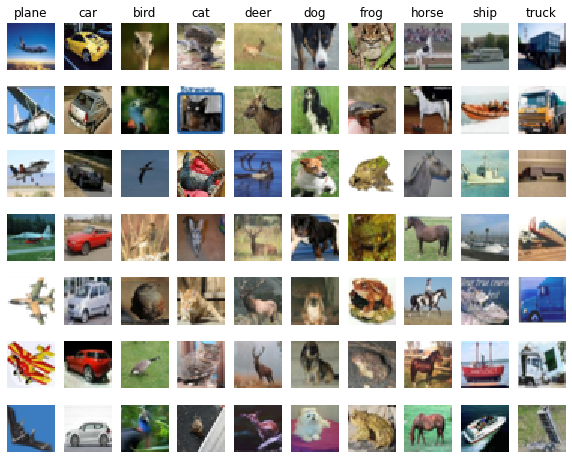

In [6]:
# Visualize some examples from the CIFAR10 dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [7]:
# Subsample the data for more efficient code execution of the KNN. For each test sample, the l2 distance to all 50000
# training samples needs to be calculated, therefore the computational complexity becomes way higher the higher the number
# of training samples
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 1000
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [8]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (1000, 3072)


In [9]:
import torch

class KNearestNeighbor(torch.nn.Module):
    """ a kNN classifier with L2 distance """
    
    def __init__(self):
        super(KNearestNeighbor, self).__init__()
        
    def train(self, X, y):
        """
        Train the classifier. For k-nearest neighbors this is just 
        memorizing the training data.
        Inputs:
        - X: An array of shape (num_train, D) containing the training data
          consisting of num_train samples each of dimension D.
        - y: An array of shape (N,) containing the training labels, where
             y[i] is the label for X[i].
        """
        self.X_train = torch.Tensor(X)
        self.y_train = torch.Tensor(y)

    def predict(self, X, k=1, num_loops=0):
        """
        Predict labels for test data using this classifier.

        Inputs:
        - X: A torch Tensor of shape (num_test, D) containing test data consisting
             of num_test samples each of dimension D.
        - k: The number of nearest neighbors that vote for the predicted labels.
        - num_loops: Determines which implementation to use to compute distances
          between training points and testing points.

        Returns:
        - y: A torch Tensor of shape (num_test,) containing predicted labels for the
          test data, where y[i] is the predicted label for the test point X[i].  
        """
        dists = self.compute_distances(X)
        return self.predict_labels(dists, k=k)

    def compute_distances(self, X):
        """
        Compute the distance between each test point in X and each training point
        in self.X_train using no explicit loops.

        Inputs:
        - X: A torch Tensor of shape (num_test, D) containing test data consisting
             of num_test samples each of dimension D.
        
        Returns:
        - dists: A torch Tensor of shape (num_test, num_train) where dists[i, j]
          gives the distance betwen the ith test point and the jth training point.
        """
        X = torch.Tensor(X)
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]

        dists = X.square().sum(dim=1).view(num_test,1) + self.X_train.square().sum(dim=1) \
                - 2 * X @ self.X_train.transpose(0,1)
        dists = dists.sqrt()
        #dists = np.reshape(np.sum(X**2, axis=1), [num_test,1]) + np.sum(self.X_train**2, axis=1) \
        #        - 2 * np.matmul(X, self.X_train.T)
        #dists = np.sqrt(dists)
        return dists

    def predict_labels(self, dists, k=1):
        """
        Given a matrix of distances between test points and training points,
        predict a label for each test point.

        Inputs:
        - dists: A torch Tensor of shape (num_test, num_train) where dists[i, j]
          gives the distance betwen the ith test point and the jth training point.

        Returns:
        - y: A torch Tensor of shape (num_test,) containing predicted labels for the
          test data, where y[i] is the predicted label for the test point X[i].  
        """
        num_test = dists.shape[0]
        y_pred = torch.zeros(num_test)
        for i in range(num_test):
            # A list of length k storing the labels of the k nearest neighbors to
            # the ith test point.
            closest_y = []
            closest_y = self.y_train[torch.argsort(dists[i])][0:k]
            y_pred[i] = torch.bincount(closest_y.int()).argmax()
        return y_pred

In [10]:
# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

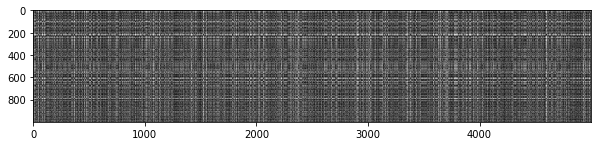

In [11]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
dists = classifier.compute_distances(X_test)
plt.imshow(dists, interpolation='none')
plt.show()

The image shows high distance in white and low distance in black. In the rows you see comparisons of single test set images with all training images. In the columns you see the comparisons of single training set images with the whole test set. 

In [12]:
# Now lets use the function predict_labels to get predictions
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

y_test_pred = y_test_pred.numpy()
# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 268 / 1000 correct => accuracy: 0.268000


You should expect to see approximately `27%` accuracy.

### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 1 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

  0%|          | 0/10 [00:00<?, ?it/s]

Best k found: 10


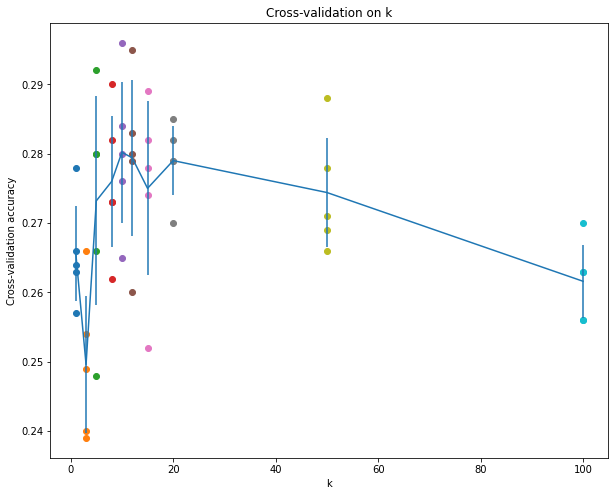

In [13]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}

for k in tqdm(k_choices):
    k_to_accuracies[k] = []
    for i in range(num_folds):
        # prepare training data for the current fold
        X_train_fold = np.concatenate([ fold for j, fold in enumerate(X_train_folds) if i != j ])
        y_train_fold = np.concatenate([ fold for j, fold in enumerate(y_train_folds) if i != j ])
        
        # use of k-nearest-neighbor algorithm
        classifier.train(X_train_fold, y_train_fold)
        y_pred_fold = classifier.predict(X_train_folds[i], k=k, num_loops=0)
        y_pred_fold = y_pred_fold.numpy()

        # Compute the fraction of correctly predicted examples
        num_correct = np.sum(y_pred_fold == y_train_folds[i])
        accuracy = float(num_correct) / X_train_folds[i].shape[0]
        k_to_accuracies[k].append(accuracy)
        
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
best_k = k_choices[accuracies_mean.argmax()]
print('Best k found:', best_k)
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [14]:
# Use best_k and run the KNN classifier again
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
dists = classifier.compute_distances(X_test)
y_test_pred = classifier.predict_labels(dists, k=best_k)
y_test_pred = y_test_pred.numpy()
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 277 / 1000 correct => accuracy: 0.277000


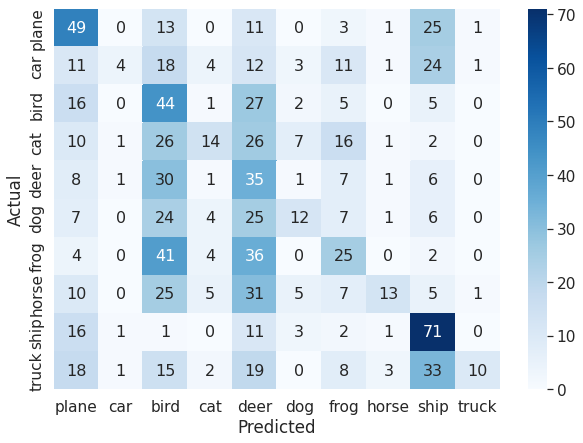

In [15]:
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

# plot a confusion matrix

def plot_confusion_matrix(y_true, y_pred):
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    data = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(data, columns=classes, index=classes)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
    plt.show()
    
plot_confusion_matrix(y_test, y_test_pred)

# Linear Classifier

This model implements a simple linear model that has for every pixel in the input image 10 parameters, one for each class in `y_true`. Predictions for a single image are obtained by calculating the inner product of input images `X` and the weight matrix `W`, such that `X @ W = logits`. Weight matrix `W` is optimized by minimizing the softmax (a.k.a. categorical cross entropy) loss function over the training data.

In [25]:
def get_CIFAR10_data(cifar10_dir, num_training=49000, num_validation=1000, 
                     num_test=1000,flatten_img=False,add_bias_neuron=False):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    if flatten_img==True:
        # Preprocessing: reshape the image data into rows
        X_train = np.reshape(X_train, (X_train.shape[0], -1))
        X_val = np.reshape(X_val, (X_val.shape[0], -1))
        X_test = np.reshape(X_test, (X_test.shape[0], -1))

        # Normalize the data: subtract the mean image
        mean_image = np.mean(X_train, axis = 0)
        X_train -= mean_image
        X_val -= mean_image
        X_test -= mean_image

        if add_bias_neuron== True:
            # add bias dimension and transform into columns
            X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
            X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
            X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    else:
        # Normalize the data: subtract the mean image
        mean_image = np.mean(X_train, axis = 0)
        X_train -= mean_image
        X_val -= mean_image
        X_test -= mean_image
        
        # Transpose so that channels come first
        X_train = X_train.transpose(0, 3, 1, 2).copy()
        X_val = X_val.transpose(0, 3, 1, 2).copy()
        X_test = X_test.transpose(0, 3, 1, 2).copy()
    
    return X_train, y_train, X_val, y_val, X_test, y_test


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data(cifar10_dir,flatten_img=True,add_bias_neuron=True)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)


In [26]:
import torch
class LinearModel(torch.nn.Module):
    """ a linear model """
    def __init__(self, X_train, y_train):
        """
        Initiliaze the linear model
        Inputs:
        - X_train: An array of shape (num_train, D) containing the training data
          consisting of num_train samples each of dimension D.
        - y_train: An array of shape (N,) containing the training labels, where
             y[i] is the label for X[i].
        """
        super(LinearModel, self).__init__()
        self.num_classes = y_train.unique().shape[0]
        self.num_train = X_train.shape[0]
        self.weights = torch.nn.Parameter(torch.rand(X_train.shape[1], num_classes, requires_grad=True)) # pixels +1 x classes

    def forward(self, X):
        """
        Computes the forward pass X @ W = logits
        Inputs:
        - X: An array of shape (batch_size, pixels+1) containing a batch of training data
          consisting of batch_size samples each of dimension pixels+1.
        Returns:
        - logits: A torch Tensor of shape (batch_size, num_classes) containing predicted labels for the
          test data, where y[i] is the predicted label for the test point X[i].  
        """
        # Compute the forward pass
        logits = X @ self.weights # num_train x classes
        return logits

In [27]:
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.Tensor(y_val)
history = {'train_loss': [],
          'val_loss': []}

epochs = 200
batch_size = 1000
num_batches = X_train.shape[0]//batch_size
#
lm = LinearModel(X_train, y_train)
loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(lm.parameters(), lr=0.5e-3) 

for epoch in tqdm(range(epochs)):
    train_loss = 0
    for x, y in zip(X_train.view(num_batches,batch_size,-1),y_train.view(num_batches,batch_size)):
        for param in lm.parameters():
            param.grad = None
        # forward
        logits = lm.forward(x)

        loss_value = loss_fn(input=logits, target=y.long()) # label.squeeze(0) for three_class
        loss_value.backward()
        optimizer.step()
        train_loss += loss_value.item()
    train_loss /= num_batches*batch_size
    # validation
    logits = lm.forward(X_val)
    val_loss = loss_fn(input=logits, target=y_val.long())
    val_loss /= logits.shape[0]
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss.item())

  0%|          | 0/200 [00:00<?, ?it/s]

In [28]:
def running_mean(x, n):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[n:] - cumsum[:-n]) / float(n)

def plot_history(history):
    # plot training and validation loss and binary accuracy
    
    loss = running_mean(history['train_loss'], 4)
    val_loss = running_mean(history['val_loss'], 4)
    #epochs = len(history.history['loss'])
    epochs = len(loss)
    fig, (ax1) = plt.subplots(1, 1, figsize=(15, 5))
    ax1.plot(range(0, epochs), loss , label='loss')
    ax1.plot(range(0, epochs), val_loss, label='val_loss')
    ax1.set_title('train and validation loss')
    ax1.legend(loc='upper right')
    plt.show()

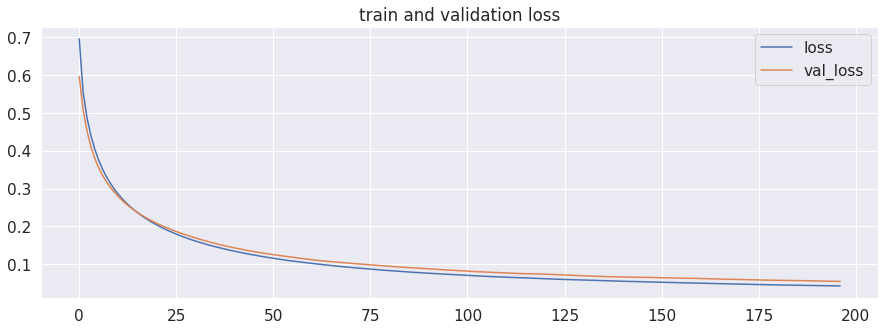

In [29]:

plot_history(history)

Got 281 / 1000 correct => accuracy: 0.281000


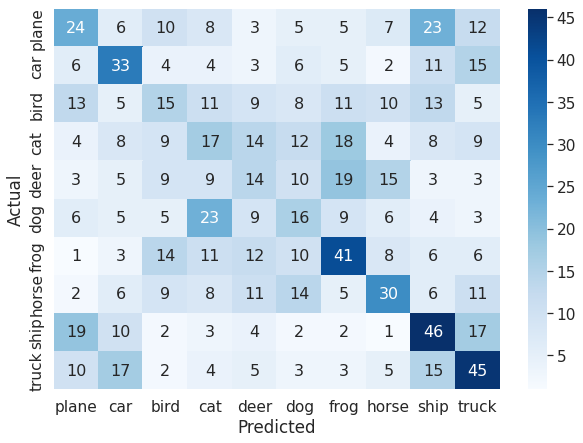

In [30]:
from sklearn.metrics import confusion_matrix

# get test set predictions
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)
logits = lm.forward(X_test)
pred_y_test = torch.nn.functional.softmax(logits, dim=1)
pred_y_test_scalar = pred_y_test.argmax(dim=1)

res = y_test.eq(pred_y_test_scalar).float()
num_correct = res.sum().item()
accuracy = res.mean().item()
num_test = res.shape[0]
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))
# plot confusion matrix
plot_confusion_matrix(y_test.numpy(),  pred_y_test_scalar.numpy())

# Artificial Neural Network (ANN)

The artifical neural network implemented below is a two layer network, which is composed by two consecutive (Fully connected layer + ReLU activation) structure. 

Due to the one more hidden layer between the input layer and the output layer, this model should perform better than the linear model. Besides, the addition of the ReLU activation behind eachfully connected layer makes this model become nonlinear and more powerful.

In [31]:
#Build ANN
import torch
class ANN(torch.nn.Module):
    """ an artificial neural network """
    def __init__(self, input_dim=3 * 32 * 32, hidden_dim=100, num_classes=10):
        """
        Initiliaze the ANN (FC+ReLU+FC+ReLU)
        Inputs:
        - input_dim: The total pixels of the input image. For the CIFAR-10 dataset, 
        this value should be 3 * 32 * 32.
        - hidden_dim: The number of neurons after hidden layer, default to be 100.
        - num_classes: For the CIFAR-10 dataset, it should be 10.
        """
        super(ANN, self).__init__()

        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.relu1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_dim, num_classes)
        self.relu2 = torch.nn.ReLU()

        # initialize the weights and bias of layers
        torch.nn.init.normal_(self.fc1.weight,0,0.01)
        torch.nn.init.normal_(self.fc2.weight,0,0.01)
        self.fc1.bias.data.fill_(0)
        self.fc2.bias.data.fill_(0)


    def forward(self,x):       
        x = self.fc1(x)       
        x = self.relu1(x)      
        x = self.fc2(x)
        x = self.relu2(x)

        return x

In [32]:
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data(cifar10_dir,
                                                                  num_training=49000, num_validation=1000,
                                                                  num_test=1000,flatten_img=True)
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.Tensor(y_val)


def train_ANN(epochs, batch_size,loss_fn,optimizer,model):
    history={
        "train_loss":[],
        "val_loss":[]
    }
    num_batches = X_train.shape[0]//batch_size
    for epoch in tqdm(range(epochs)):
        train_loss = 0
        i=0
        for x, y in zip(X_train.view(num_batches,batch_size,-1),y_train.view(num_batches,batch_size)):
            model.train()
            for param in model.parameters():
                param.grad = None
            # forward
            logits = model.forward(x)

            loss_value = loss_fn(input=logits, target=y.long()) # label.squeeze(0) for three_class
            loss_value.backward()
            optimizer.step()
            train_loss += loss_value.item()
            i=i+1
        train_loss /= (num_batches*batch_size)
        # validation
        model.eval()
        with torch.no_grad():
            logits = model.forward(X_val)
            val_loss = loss_fn(input=logits, target=y_val.long())
            val_loss /= logits.shape[0]
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss.item())
        print(f"epoch={epoch+1}, train_loss={train_loss}, val_loss={val_loss.item()}")
    return model, history, optimizer 

In [33]:
#start training and plot training history
loss_fn = torch.nn.CrossEntropyLoss(reduction='sum')
model=ANN(hidden_dim=100) #CHANGE
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
model,ANN_history,_=train_ANN(30, 1000,loss_fn,optimizer,model)


  0%|          | 0/30 [00:00<?, ?it/s]

epoch=1, train_loss=2.165041563695791, val_loss=1.9463051557540894
epoch=2, train_loss=1.8568841577646684, val_loss=1.7863234281539917
epoch=3, train_loss=1.733951662647481, val_loss=1.698880910873413
epoch=4, train_loss=1.6512702063735651, val_loss=1.6489309072494507
epoch=5, train_loss=1.5887345468949299, val_loss=1.6134238243103027
epoch=6, train_loss=1.5371894456513073, val_loss=1.585647463798523
epoch=7, train_loss=1.494771783322704, val_loss=1.5639499425888062
epoch=8, train_loss=1.45877386848294, val_loss=1.543318510055542
epoch=9, train_loss=1.4277101801658163, val_loss=1.5273211002349854
epoch=10, train_loss=1.3994916319555166, val_loss=1.5112817287445068
epoch=11, train_loss=1.373822078782685, val_loss=1.4993371963500977
epoch=12, train_loss=1.3512626006457271, val_loss=1.4890583753585815
epoch=13, train_loss=1.3306163504464286, val_loss=1.4807500839233398
epoch=14, train_loss=1.3120145487882653, val_loss=1.4727563858032227
epoch=15, train_loss=1.29476763542331, val_loss=1.46

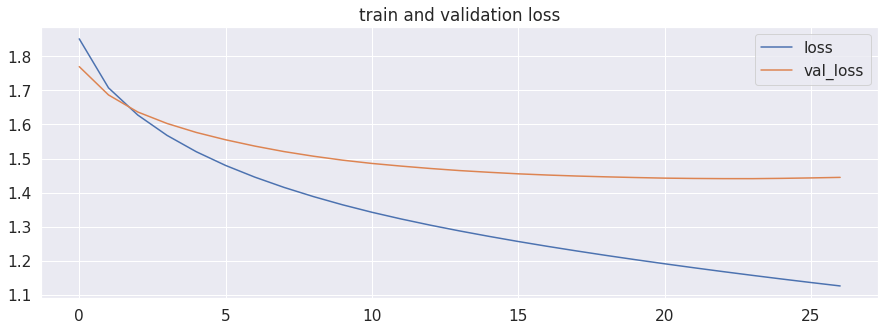

In [34]:
plot_history(ANN_history)

Got 507 / 1000 correct => accuracy: 0.507000


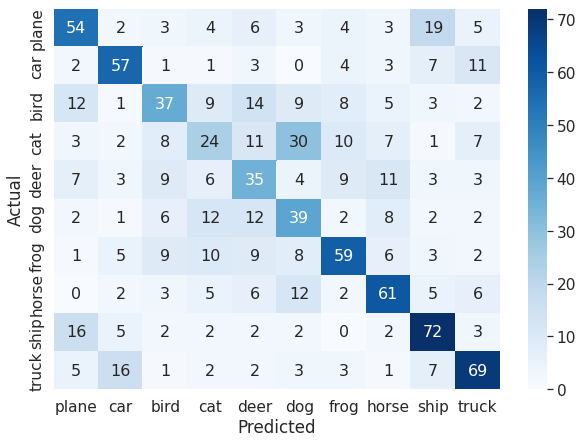

In [35]:

# get test set predictions
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)
logits = model(X_test)
pred_y_test = torch.nn.functional.softmax(logits, dim=1)
pred_y_test_scalar = pred_y_test.argmax(dim=1)

res = y_test.eq(pred_y_test_scalar).float()
num_correct = res.sum().item()
accuracy = res.mean().item()
num_test = res.shape[0]
# the accuracy should be around 0.5
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))
# plot confusion matrix
plot_confusion_matrix(y_test.numpy(),  pred_y_test_scalar.numpy())

# Convolutional Neural Network (CNN)

A convolutional neural network (CNN, or ConvNet) is a class of artificial neural network which contains the convolutional layer and employs a mathematical operation called convolution. Convolutional networks were inspired by biological processe in that the connectivity pattern between neurons resembles the organization of the animal visual cortex.

Compared with the last 2-layer network, the first fully connected layer is replaced by the convolutional layer and the MaxPool layer will help to reduce the number of parameters in the network. Also keep in mind that it is much faster to run the convolution operation on the GPU device.

In [36]:
#Build CNN
class CNN(torch.nn.Module):
    """ an convolutional neural network """
    def __init__(self,img_channels,N_outchannels,num_classes,kernel_size=3,maxpool_F=2):
        """
        Initiliaze the CNN (Conv2d+ReLU+MaxPool2d+FC)
        Inputs:
        - img_channels: The number of channels of the input image. For the RGB image, 
        the value should be 3.
        - N_outchannels: The output channel number after the first convlutional layer.
        - num_classes: For the CIFAR-10 dataset, it should be 10.
        - kernel_size: The kernel size of the first convolutional layer, default to be 3.
        - maxpool_F: The pooling factor of the MaxPool layer, default to be 2.
        """
        super(CNN, self).__init__()

        self.conv1 = torch.nn.Conv2d(img_channels, N_outchannels, kernel_size, stride=1,padding=0)
        self.relu1 = torch.nn.ReLU()
        # 32*32*3--> 30*30*N_outchannels
        self.maxpool1 = torch.nn.MaxPool2d(maxpool_F,stride=maxpool_F)
        # 30*30*N_outchannels--> 15*15*N_outchannels       
        self.fc1 = torch.nn.Linear(15*15*N_outchannels, num_classes)

        # initialize the weights and bias of layers
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        torch.nn.init.normal_(self.fc1.weight,0,0.01)
        self.fc1.bias.data.fill_(0)
        


    def forward(self,x):
        x=self.conv1(x)
        x=self.relu1(x)
        x=self.maxpool1(x)
        x=torch.flatten(x, 1)
        x=self.fc1(x)

        return x

In [37]:
# create the training data and validation data, making sure their shape to be 
# torch.Size([49000, 3, 32, 32]) torch.Size([49000]) for training data
# torch.Size([49000, 3, 32, 32]) torch.Size([49000]) for validation data
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data(cifar10_dir,
                                                                  num_training=49000, num_validation=1000, 
                                                                  num_test=1000)
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.Tensor(y_val)
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)

torch.Size([49000, 3, 32, 32]) torch.Size([49000])
torch.Size([1000, 3, 32, 32]) torch.Size([1000])


In [38]:
def train_CNN(epochs, batch_size,loss_fn,optimizer,model,device,X_train,y_train,X_val,y_val):
    history={
        "train_loss":[],
        "val_loss":[]
    }
    num_batches = X_train.shape[0]//batch_size
    for epoch in tqdm(range(epochs)):
        train_loss = 0
        i=0
        for x, y in zip(X_train.view(num_batches,batch_size,3,32,32),y_train.view(num_batches,batch_size)):
            model.train()
            x=x.to(device)
            y=y.to(device)
            for param in model.parameters():
                param.grad = None
            # forward
            logits = model.forward(x)
            loss_value = loss_fn(input=logits, target=y.long()) # label.squeeze(0) for three_class
            loss_value.backward()
            optimizer.step()
            train_loss += loss_value.item()
            i=i+1
        train_loss /= (num_batches*batch_size)
        # validation
        model.eval()
        with torch.no_grad():
            X_val=X_val.to(device)
            y_val=y_val.to(device)
            logits = model.forward(X_val)
            val_loss = loss_fn(input=logits, target=y_val.long())
            val_loss /= logits.shape[0]
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss.item())
        print(f"epoch={epoch+1}, train_loss={train_loss}, val_loss={val_loss.item()}")
    return model, history, optimizer 

In [39]:
#start training and plot training history
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

loss_fn = torch.nn.CrossEntropyLoss(reduction='sum')
model=CNN(img_channels=3,N_outchannels=100,num_classes=10) #CHANGE
model=model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
model,CNN_history,_=train_CNN(30, 1000,loss_fn,optimizer,model,device,X_train,y_train,X_val,y_val)


  0%|          | 0/30 [00:00<?, ?it/s]

epoch=1, train_loss=10.734637834821429, val_loss=7.211390018463135
epoch=2, train_loss=5.964581901705995, val_loss=5.1751909255981445
epoch=3, train_loss=4.610025101642219, val_loss=4.2358551025390625
epoch=4, train_loss=3.8829813954878825, val_loss=3.7097034454345703
epoch=5, train_loss=3.4186719048947705, val_loss=3.3788952827453613
epoch=6, train_loss=3.0906546257174745, val_loss=3.1487627029418945
epoch=7, train_loss=2.8445306919642857, val_loss=2.9776790142059326
epoch=8, train_loss=2.6508835748166453, val_loss=2.842149257659912
epoch=9, train_loss=2.4916412328603315, val_loss=2.7298669815063477
epoch=10, train_loss=2.356045539700255, val_loss=2.634866237640381
epoch=11, train_loss=2.238907784598214, val_loss=2.5563642978668213
epoch=12, train_loss=2.1379933608697383, val_loss=2.488447904586792
epoch=13, train_loss=2.049382451271524, val_loss=2.417905569076538
epoch=14, train_loss=1.9682915138711734, val_loss=2.354156255722046
epoch=15, train_loss=1.894940858179209, val_loss=2.302

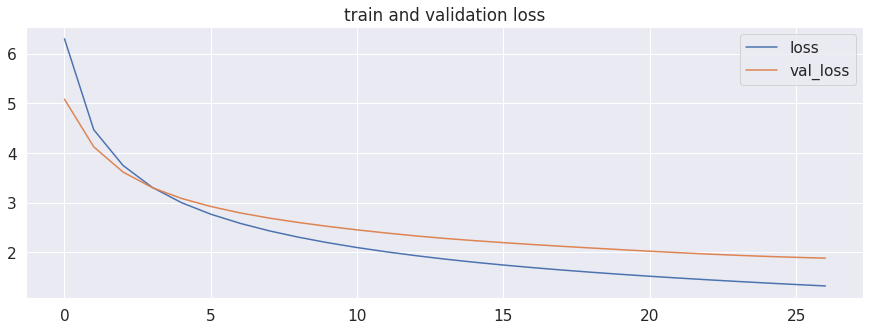

In [40]:
plot_history(CNN_history)

Got 545 / 1000 correct => accuracy: 0.545000


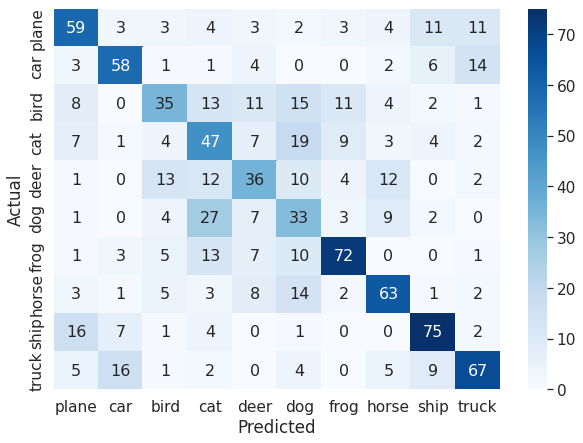

In [41]:
#show result on test data

# get test set predictions
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

X_test=X_test.to(device)
logits = model(X_test)

logits=logits.cpu().detach()
pred_y_test = torch.nn.functional.softmax(logits, dim=1)
pred_y_test_scalar = pred_y_test.argmax(dim=1)

res = y_test.eq(pred_y_test_scalar).float()
num_correct = res.sum().item()
accuracy = res.mean().item()
num_test = res.shape[0]
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))
# plot confusion matrix
plot_confusion_matrix(y_test.numpy(),  pred_y_test_scalar.numpy())